# Advantage Actor-Critic (A2C)

## Введение

**A2C (Advantage Actor-Critic)** - это алгоритм обучения с подкреплением, который объединяет преимущества методов градиента политики (Policy Gradient) и методов оценки ценности (Value Function).

### Что такое Actor-Critic?

**Actor-Critic** - это смешанный подход, который включает:
- **Actor (Актор)**: Сеть политики $\pi(a|s)$, которая определяет, какое действие выбрать в данном состоянии
- **Critic (Критик)**: Сеть оценки ценности $V(s)$, которая оценивает, насколько хорошо находиться в данном состоянии

### Преимущества A2C

1. **Снижение дисперсии**: Использование функции ценности (Critic) для оценки преимущества (advantage) снижает дисперсию градиентов по сравнению с методами только на основе политики
2. **Более стабильное обучение**: Critic предоставляет baseline для оценки качества действий
3. **Эффективность**: Может обучаться быстрее, чем методы только на основе политики

### Как работает A2C?

В этом алгоритме агент одновременно обучает две сети:
- **Actor (политика)**: Используется для предсказания действия на каждом шаге
- **Critic (V-функция)**: Используется для аппроксимации ожидаемого будущего вознаграждения из состояния

**Ключевая идея**: Используем **advantage** (преимущество) $A(s,a) = Q(s,a) - V(s)$ для оценки того, насколько лучше или хуже действие по сравнению со средним значением в данном состоянии.

## Алгоритм A2C

### Математические основы

**Advantage функция**:
$$ A(s_t, a_t) = Q(s_t, a_t) - V(s_t) $$

где:
- $Q(s_t, a_t)$ - ожидаемое будущее вознаграждение при выполнении действия $a_t$ в состоянии $s_t$
- $V(s_t)$ - ожидаемое будущее вознаграждение из состояния $s_t$

**Оценка advantage через TD-ошибку**:
$$ A(s_t, a_t) \approx r_t + \gamma V(s_{t+1}) - V(s_t) $$

Это называется **TD-ошибкой** (Temporal Difference error) и используется как оценка преимущества действия.

### Алгоритм обучения

1. **Инициализация**: Случайно инициализируем сети:
   - Actor (политика): $\pi(a|s)$ с параметрами $\theta^{\mu}$
   - Critic (V-функция): $V(s)$ с параметрами $\theta^V$

2. **Для каждого эпизода**:
   - Собираем траекторию $(s_0, a_0, r_0, s_1, a_1, r_1, ..., s_T)$
   - Вычисляем дисконтированные награды для каждого состояния
   - Обучаем Critic и Actor

3. **Обучение Critic**:
   - Функция потерь: $Loss(\theta^V) = \big( r_t + \gamma V(s_{t+1}) - V(s_t) \big)^2$
   - **Минимизируем** эту функцию потерь (градиентный спуск)
   - Цель: научить $V(s)$ точно предсказывать ожидаемое будущее вознаграждение

4. **Обучение Actor**:
   - Функция потерь: $Loss(\theta^{\mu}) = -\ln{\pi(a_t|s_t)} \cdot A(s_t, a_t)$
   - **Максимизируем** эту функцию (градиентный подъем, поэтому знак минус)
   - Цель: увеличить вероятность хороших действий (с положительным advantage) и уменьшить вероятность плохих

> **Важно**: 
> - Для Critic используем **градиентный спуск** (минимизация потерь)
> - Для Actor используем **градиентный подъем** (максимизация награды, поэтому знак минус в loss)

### Обновление параметров

- $\theta^V \gets \theta^V - \alpha \nabla_{\theta^V}Loss(\theta^V)$ (градиентный спуск)
- $\theta^{\mu} \gets \theta^{\mu} + \beta \nabla_{\theta^{\mu}}Loss(\theta^{\mu})$ (градиентный подъем)

где $\alpha$ и $\beta$ - скорости обучения для Critic и Actor соответственно.

## Среда CartPole

**CartPole** - классическая задача обучения с подкреплением, где нужно балансировать шест на тележке.

**Описание задачи**:
- **Состояние**: 4 измерения (позиция тележки, скорость тележки, угол шеста, угловая скорость шеста)
- **Действия**: 2 дискретных действия (толкнуть тележку влево или вправо)
- **Цель**: Удержать шест в вертикальном положении как можно дольше
- **Максимальная награда**: 500 шагов

Подробнее: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

<img src="https://www.gymlibrary.dev/_images/cart_pole.gif" width=400 height=400 />

## Импорты библиотек

Импортируем необходимые библиотеки для реализации A2C.

In [1]:
# Библиотеки для работы со средой
import gymnasium as gym

# Библиотеки для численных вычислений
import numpy as np

# Библиотеки для глубокого обучения
import torch
import torch.nn as nn
from torch.nn import functional as F

# Библиотека для визуализации
import matplotlib.pyplot as plt

In [2]:
gym.__version__

'1.2.3'

## Архитектура сетей

Создаем две нейронные сети:

1. **ActorNet** - сеть политики для выбора действий
2. **ValueNet** - сеть оценки ценности состояний

Обе сети имеют простую архитектуру с одним скрытым слоем.

In [3]:
# Выбираем устройство для вычислений (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorNet(nn.Module):
    """
    Сеть Actor (политика) для выбора действий.
    
    Возвращает logits (логиты) для каждого возможного действия.
    После применения softmax получаем вероятности действий.
    
    Args:
        hidden_dim: размерность скрытого слоя (по умолчанию 16)
    """
    def __init__(self, hidden_dim=16):
        super().__init__()
        # Входной размер: 4 (состояние CartPole)
        self.hidden = nn.Linear(4, hidden_dim)
        # Выходной размер: 2 (количество возможных действий: влево/вправо)
        self.output = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        """
        Прямой проход через сеть.
        
        Args:
            s: тензор состояний [batch_size, 4]
        
        Returns:
            Logits для действий [batch_size, 2]
        """
        # Проходим через скрытый слой с ReLU активацией
        outs = self.hidden(s)
        outs = F.relu(outs)
        # Получаем logits (до применения softmax)
        logits = self.output(outs)
        return logits

class ValueNet(nn.Module):
    """
    Сеть Critic (V-функция) для оценки ценности состояний.
    
    Оценивает ожидаемое будущее вознаграждение из данного состояния.
    
    Args:
        hidden_dim: размерность скрытого слоя (по умолчанию 16)
    """
    def __init__(self, hidden_dim=16):
        super().__init__()
        # Входной размер: 4 (состояние CartPole)
        self.hidden = nn.Linear(4, hidden_dim)
        # Выходной размер: 1 (оценка ценности состояния)
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, s):
        """
        Прямой проход через сеть.
        
        Args:
            s: тензор состояний [batch_size, 4]
        
        Returns:
            Оценки ценности состояний [batch_size, 1]
        """
        # Проходим через скрытый слой с ReLU активацией
        outs = self.hidden(s)
        outs = F.relu(outs)
        # Получаем оценку ценности состояния
        value = self.output(outs)
        return value

# Создаем экземпляры сетей и перемещаем их на выбранное устройство
actor_func = ActorNet().to(device)  # Сеть политики (Actor)
value_func = ValueNet().to(device)  # Сеть оценки ценности (Critic)

In [4]:
def pick_sample(s):
    """
    Выбирает действие на основе текущей политики (Actor).
    
    Процесс:
    1. Получаем logits от сети политики
    2. Применяем softmax для получения вероятностей действий
    3. Сэмплируем действие из распределения вероятностей
    
    Args:
        s: текущее состояние (массив numpy размерности 4)
    
    Returns:
        Выбранное действие (0 или 1 для CartPole)
    """
    # Отключаем вычисление градиентов (только инференс)
    with torch.no_grad():
        # Преобразуем состояние в тензор и добавляем размерность батча
        # s: (4,) -> s_batch: (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        
        # Получаем logits от сети политики
        # logits: (1, 2) - по одному значению для каждого действия
        logits = actor_func(s_batch)
        
        # Убираем размерность батча
        # logits: (1, 2) -> (2,)
        logits = logits.squeeze(dim=0)
        
        # Преобразуем logits в вероятности с помощью softmax
        # probs: (2,) - вероятности для действий [влево, вправо]
        probs = F.softmax(logits, dim=-1)
        
        # Сэмплируем действие из распределения вероятностей
        # Это обеспечивает исследование: даже если одно действие более вероятно,
        # иногда может быть выбрано другое действие
        a = torch.multinomial(probs, num_samples=1)
        
        # Возвращаем действие как обычное число (0 или 1)
        return a.tolist()[0]

## Основной цикл обучения

В этом разделе реализуем основной цикл обучения A2C:

1. **Сбор траектории**: Проходим эпизод, собирая состояния, действия и награды
2. **Вычисление дисконтированных наград**: Вычисляем суммарные будущие награды для каждого состояния
3. **Обучение Critic**: Минимизируем ошибку предсказания ценности состояний
4. **Обучение Actor**: Максимизируем вероятность хороших действий (с положительным advantage)

In [5]:
# Коэффициент дисконтирования для будущих вознаграждений
gamma = 0.99

# Создаем среду CartPole
env = gym.make("CartPole-v1")

# Массив для записи наград по эпизодам
reward_records = []

# Оптимизаторы для обеих сетей
opt1 = torch.optim.AdamW(value_func.parameters(), lr=0.001)  # для Critic
opt2 = torch.optim.AdamW(actor_func.parameters(), lr=0.001)   # для Actor

# Количество эпизодов обучения
num_episodes = 1500

# Основной цикл обучения
for i in range(num_episodes):
    # ========== ЭТАП 1: СБОР ТРАЕКТОРИИ ==========
    # В начале эпизода инициализируем массивы для хранения траектории
    done = False
    states = []   # список состояний в эпизоде
    actions = []  # список выполненных действий
    rewards = []  # список полученных наград
    
    # Сбрасываем среду и получаем начальное состояние
    s, _ = env.reset()

    # Проходим эпизод до завершения
    while not done:
        # Сохраняем текущее состояние
        states.append(s.tolist())
        
        # Выбираем действие на основе текущей политики (Actor)
        a = pick_sample(s)
        
        # Выполняем действие в среде
        # Возвращает: следующее состояние, награду, флаги завершения (terminated, truncated)
        s, r, term, trunc, _ = env.step(a)
        
        # Проверяем, завершен ли эпизод
        done = term or trunc
        
        # Сохраняем действие и награду
        actions.append(a)
        rewards.append(r)

    # ========== ЭТАП 2: ВЫЧИСЛЕНИЕ ДИСКОНТИРОВАННЫХ НАГРАД ==========
    # Вычисляем суммарные будущие награды для каждого состояния в траектории
    # Используем обратный проход: награда в состоянии t = текущая награда + 
    # дисконтированная награда из следующего состояния
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    
    # Проходим траекторию в обратном порядке
    for j in reversed(range(reward_len)):
        # Награда = текущая награда + дисконтированная награда из следующего шага
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma if j+1 < reward_len else 0)

    # ========== ЭТАП 3: ОБУЧЕНИЕ CRITIC (V-функция) ==========
    # Минимизируем ошибку предсказания ценности состояний
    opt1.zero_grad()  # обнуляем градиенты
    
    # Преобразуем данные в тензоры PyTorch
    states = torch.tensor(states, dtype=torch.float).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)

    # Получаем предсказания ценности состояний от Critic
    values = value_func(states)
    values = values.squeeze(dim=1)  # убираем лишнюю размерность
    
    # Функция потерь: MSE между предсказанными и реальными дисконтированными наградами
    # Цель: научить V(s) точно предсказывать ожидаемое будущее вознаграждение
    vf_loss = F.mse_loss(values, cum_rewards, reduction="none")
    
    # Обратное распространение и обновление параметров
    vf_loss.sum().backward()
    opt1.step()  # градиентный спуск (минимизация)

    # ========== ЭТАП 4: ОБУЧЕНИЕ ACTOR (политика) ==========
    # Максимизируем вероятность хороших действий (с положительным advantage)
    
    # Получаем значения V(s) для вычисления advantage
    # Важно: отключаем градиенты, чтобы не обновлять Critic при обучении Actor
    with torch.no_grad():
        values = value_func(states)

    # Обнуляем градиенты для Actor
    opt2.zero_grad()
    
    # Преобразуем действия в тензор
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    
    # Вычисляем advantage: A(s,a) = Q(s,a) - V(s) ≈ cum_rewards - V(s)
    # Advantage показывает, насколько лучше/хуже действие по сравнению со средним
    advantages = cum_rewards - values

    # Вычисляем функцию потерь для Actor
    logits = actor_func(states)
    # log_probs: логарифм вероятности выбранных действий
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    
    # Функция потерь: -log_prob * advantage
    # Знак минус потому что мы максимизируем (градиентный подъем)
    # Умножение на advantage: увеличиваем вероятность действий с положительным advantage
    pi_loss = -log_probs * advantages
    
    # Обратное распространение и обновление параметров
    pi_loss.sum().backward()
    opt2.step()  # градиентный подъем (максимизация)

    # ========== ЛОГИРОВАНИЕ И ПРОВЕРКА ==========
    # Записываем суммарную награду эпизода (максимум 500 для CartPole)
    reward_records.append(sum(rewards))

    # Выводим среднюю награду каждые 100 эпизодов
    if i % 100 == 0:
        print("Эпизод {}: средняя награда {}".format(i, np.mean(reward_records[-100:])), end="\r")

    # Останавливаем обучение, если средняя награда за последние 100 эпизодов > 475
    # Это означает, что агент научился хорошо решать задачу
    if np.average(reward_records[-100:]) > 475.0:
        print(f"\nОбучение завершено на эпизоде {i}!")
        break

print("\nОбучение завершено!")
env.close()

Эпизод 1100: средняя награда 470.28
Обучение завершено на эпизоде 1130!

Обучение завершено!


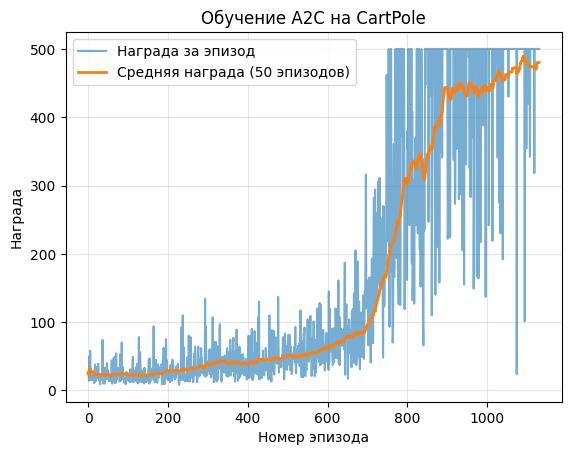

In [6]:
# Вычисляем скользящее среднее за последние 50 эпизодов
# Это помогает увидеть тренд обучения, сглаживая шум
average_reward = []
for idx in range(len(reward_records)):
    if idx < 50:
        # Если эпизодов меньше 50, берем все доступные
        avg_list = reward_records[:idx+1]
    else:
        # Иначе берем последние 50 эпизодов
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))

# Строим графики обучения
plt.plot(reward_records, label='Награда за эпизод', alpha=0.6)
plt.plot(average_reward, label='Средняя награда (50 эпизодов)', linewidth=2)
plt.xlabel('Номер эпизода')
plt.ylabel('Награда')
plt.title('Обучение A2C на CartPole')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()